$$
\begin{cases}
u_{tt}(x, y, t) = u_{xx}(x, y, t) + u_{yy}(x, y, t) + f(x, y, t), & (x, y, t) \in \Omega \times (0, T] \\[2ex]
u(x, y, 0) = \sin(x)\sin(y), & (x, y) \in \overlineΩ \\[2ex]
u_t(x, y, 0) = -\sin(x)\sin(y), & (x, y) \in \overlineΩ \\[2ex]
u(x, y, t) = e^{-t} \sin(x)\sin(y), & (x, y, t) \in \partial\Omega \\[2ex]
\end{cases}
$$
\
$$
r(\theta) = \frac{0.3}{n^2}(1 + 2n + n^2 - (n+1)\cos(n\theta))
$$

\\
**Analytical Solution:**
$$
u(x, y, t) = e^{-t} \sin(x)\sin(y)
$$


In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def IrregularDomain(n, h):
    t = jnp.linspace(0, 2 * jnp.pi, 200)
    r_b = (0.3/(n**2)) * (1 + 2*n + n**2 - (n+1)*jnp.cos(n*t))
    xb = r_b * jnp.cos(t)
    yb = r_b * jnp.sin(t)
    xb = xb.reshape(-1, 1)
    yb = yb.reshape(-1, 1)
    xx, yy = jnp.meshgrid(jnp.arange(-0.5, 0.5 + h, h), jnp.arange(-0.5, 0.5 + h, h))
    teta, r = jnp.arctan2(yy, xx), jnp.sqrt(xx**2 + yy**2)
    r_boundary = (0.3/(n**2)) * (1 + 2*n + n**2 - (n+1)*jnp.cos(n*teta))
    inside = r < r_boundary - 0.01
    xd = xx[inside].reshape(-1, 1)
    yd = yy[inside].reshape(-1, 1)
    return xb, yb, xd, yd

def u_true(x, y, t):
    return jnp.exp(-t) * jnp.sin(x) * jnp.sin(y)

def f(x, y, t):
    return 3 * jnp.exp(-t) * jnp.sin(x) * jnp.sin(y)

In [ ]:
n = 7
h = 0.05
T = 1.0

xb, yb, xd, yd = IrregularDomain(n, h)
N_b = xb.shape[0]
N_d = xd.shape[0]
N_t = 100

t_b = jnp.linspace(0, T, N_t).reshape(-1, 1)
Xb = jnp.tile(xb, (N_t, 1))
Yb = jnp.tile(yb, (N_t, 1))
Tb = jnp.repeat(t_b, N_b, axis=0)
BC = jnp.concatenate([Xb, Yb, Tb, u_true(Xb, Yb, Tb)], axis=1)
t0 = jnp.zeros_like(xd)
IC1 = jnp.concatenate([xd, yd, t0, u_true(xd, yd, t0)], axis=1)
IC2 = jnp.concatenate([xd, yd, t0, -u_true(xd, yd, t0)], axis=1)
key = jax.random.PRNGKey(123)
tc = jax.random.uniform(key, (N_d, 1), minval=0, maxval=T)
colloc = jnp.concatenate([xd, yd, tc], axis=1)

def init_params(layers):
    keys = jax.random.split(jax.random.PRNGKey(0), len(layers) - 1)
    params = []
    for key, n_in, n_out in zip(keys, layers[:-1], layers[1:]):
        lb, ub = -(1 / jnp.sqrt(n_in)), (1 / jnp.sqrt(n_in))
        W = lb + (ub - lb) * jax.random.uniform(key, shape=(n_in, n_out))
        B = jax.random.uniform(key, shape=(n_out,))
        params.append({'W': W, 'B': B})
    return params

def fwd(params, x, y, t):
    X = jnp.concatenate([x, y, t], axis=1)
    *hidden, last = params
    for layer in hidden:
        X = jax.nn.tanh(X @ layer['W'] + layer['B'])
    return X @ last['W'] + last['B']

In [ ]:
def PDE_loss(x, y, t, ufunc):
    def u_single(x, y, t):
        return ufunc(jnp.array([[x]]), jnp.array([[y]]), jnp.array([[t]])).reshape(())
    u_tt_vec = jax.vmap(jax.grad(jax.grad(u_single, argnums=2), argnums=2))
    u_xx_vec = jax.vmap(jax.grad(jax.grad(u_single, argnums=0), argnums=0))
    u_yy_vec = jax.vmap(jax.grad(jax.grad(u_single, argnums=1), argnums=1))
    res = u_tt_vec(x.flatten(), y.flatten(), t.flatten()) \
        - u_xx_vec(x.flatten(), y.flatten(), t.flatten()) \
        - u_yy_vec(x.flatten(), y.flatten(), t.flatten()) \
        - f(x.flatten(), y.flatten(), t.flatten())
    return res

In [ ]:
@jax.jit
def MSE(true, pred):
    return jnp.mean((true - pred) ** 2)

def loss_fun(params, colloc, BC, IC1, IC2):
    x_c, y_c, t_c = colloc[:, [0]], colloc[:, [1]], colloc[:, [2]]
    ufunc = lambda x, y, t: fwd(params, x, y, t)
    res = PDE_loss(x_c, y_c, t_c, ufunc)
    loss = jnp.mean(res ** 2)
    x_b, y_b, t_b, u_b = BC[:, [0]], BC[:, [1]], BC[:, [2]], BC[:, [3]]
    loss += MSE(ufunc(x_b, y_b, t_b), u_b)
    x0, y0, t0, u0 = IC1[:, [0]], IC1[:, [1]], IC1[:, [2]], IC1[:, [3]]
    loss += MSE(ufunc(x0, y0, t0), u0)
    x0v, y0v, t0v, ut0 = IC2[:, [0]], IC2[:, [1]], IC2[:, [2]], IC2[:, [3]]
    u_t = lambda x, y, t: jax.grad(lambda t_: fwd(params, jnp.array([[x]]), jnp.array([[y]]), jnp.array([[t_]])).reshape(()))(t)
    u_t_vec = jax.vmap(u_t)
    loss += MSE(u_t_vec(x0v.flatten(), y0v.flatten(), t0v.flatten()), ut0.flatten())
    return loss

In [ ]:
params = init_params([3] + [20]*4 + [1])
lr = optax.piecewise_constant_schedule(1e-2, {10_000: 5e-3, 30_000: 1e-3})
optimizer = optax.adam(lr)
opt_state = optimizer.init(params)

@jax.jit
def update(opt_state, params, colloc, BC, IC1, IC2):
    grads = jax.grad(loss_fun, 0)(params, colloc, BC, IC1, IC2)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return opt_state, params

Epoch=0	loss=8.937e-02
Epoch=100	loss=2.070e-03
Epoch=200	loss=5.927e-04
Epoch=300	loss=2.586e-04
Epoch=400	loss=2.644e-05
Epoch=500	loss=2.535e-05
Epoch=600	loss=1.260e-05
Epoch=700	loss=5.585e-05
Epoch=800	loss=4.997e-05
Epoch=900	loss=1.487e-04


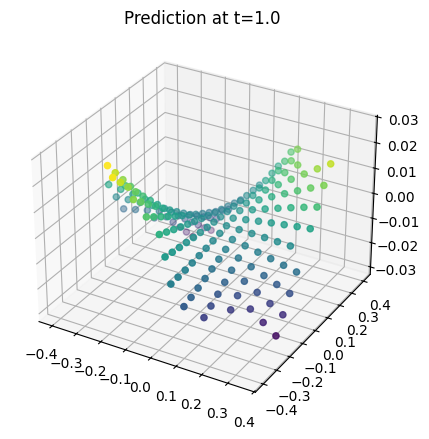

Max abs error: 0.003550393506884575


In [ ]:
epochs = 1000
for ep in range(epochs):
    opt_state, params = update(opt_state, params, colloc, BC, IC1, IC2)
    if ep % 100 == 0:
        l = float(loss_fun(params, colloc, BC, IC1, IC2))
        print(f'Epoch={ep}\tloss={l:.3e}')

def plot_solution(params, xd, yd, tval, title):
    tplot = jnp.full_like(xd, tval)
    pred = fwd(params, xd, yd, tplot)
    true = u_true(xd, yd, tplot)
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(xd, yd, pred, c=pred, cmap='viridis')
    ax.set_title(title)
    plt.show()
    print("Max abs error:", float(jnp.max(jnp.abs(pred - true))))

plot_solution(params, xd, yd, 1.0, "Prediction at t=1.0")
